In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
def eval(model, data, labels):
    predicted = model(data)
    errors = F.mse_loss(predicted, labels)
    return float(errors) / predicted.shape[0]

class Net(nn.Module):
    def __init__(self, input_dim, output_dimension, hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, output_dimension)

    def forward(self, x):
        x = self.fc1(x)
        x = Net._requ(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    @staticmethod
    def _requ(x):
        return F.relu(x).pow(2)

In [4]:
switcher = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}

train_input = []
train_labels = []

# loading data
data_frame = pd.read_csv('/home/nivkeren/PycharmProjects/Deep_Learning_Course/EX1/Q3/training.csv', sep=',').dropna()
Y = (data_frame.iloc[:, 0:-1].values / 48) - 1

img_df = data_frame.iloc[:, -1]

img_df.to_csv('.img.csv', index=False)
X = pd.read_csv('.img.csv', sep=' ', header=None).values / 255

[[66.03356391 39.00227368]
 [30.22700752 36.4216782 ]
 [59.58207519 39.64742256]
 [73.13034586 39.96999699]
 [36.35657143 37.3894015 ]
 [23.45287218 37.3894015 ]
 [56.95326316 29.03364812]
 [80.22712782 32.22813835]
 [40.22760902 29.0023218 ]
 [16.35637895 29.64747068]
 [44.42057143 57.06680301]
 [61.19530827 79.97016541]
 [28.61449624 77.38899248]
 [43.3126015  72.93545865]
 [43.13070677 84.48577444]]


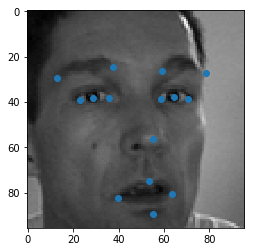

In [5]:
Y_t = ((Y + 1) * 48).reshape(-1, 15, 2)
print(Y_t[0])
plt.imshow(X[101].reshape(96, 96), cmap="gray")
plt.scatter(Y_t[101, :, 0], Y_t[101, :, 1])
plt.show()

In [6]:
class View(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [7]:
conv_model = nn.Sequential(nn.Conv2d(1, 32, 3),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           nn.Conv2d(32,64, 2),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           nn.Conv2d(64, 128, 2),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           View(),
                           nn.Linear(15488, 500),
                           nn.ReLU(),
                           nn.Linear(500, 500),
                           nn.ReLU(),
                           nn.Linear(500, 30)).to(device=device)

In [8]:
mask = np.arange(0, 2140)
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * 0.15)]
train_mask = mask[int(X.shape[0] * 0.15):]
X_val = torch.FloatTensor(X[val_mask]).view((-1, 1, 96, 96)).to(device=device)
X_train = torch.FloatTensor(X[train_mask]).view((-1, 1, 96, 96)).to(device=device)
Y_val = torch.FloatTensor(Y[val_mask]).to(device=device)
Y_train = torch.FloatTensor(Y[train_mask]).to(device=device)

print(X_train.shape)

torch.Size([1819, 1, 96, 96])


In [9]:
C = 1
L = 96
W = 96
N = 2140
flatten_dim = L * W
output_dim = 30
h = 100

linear_model = torch.nn.Sequential(nn.Linear(flatten_dim, h), nn.ReLU(), nn.Linear(h, output_dim))

In [ ]:
# cross_entropy = nn.CrossEntropyLoss().cuda()
loss_fn = nn.MSELoss()

optimizer = optim.Adam(linear_model.parameters(), lr=1e-2)
# train model
train_loss = []
val_loss = []

iteration_number = 1000
for iteration in range(iteration_number):
    # forward pass
    y_pred = conv_model(X_train)
    # Calculate Loss
    loss = loss_fn(y_pred, Y_train)
    # optimization
    optimizer.zero_grad()
    # backward propagation
    loss.backward()
    # Updating parameters
    optimizer.step()
    train_loss.append(eval(conv_model, X_train, Y_train))
    val_loss.append(eval(conv_model, X_val, Y_val))

In [ ]:
# plt.plot(np.arange(iteration_number), train_loss)
# plt.plot(np.arange(iteration_number), val_loss)
pred = ((conv_model(X_val) + 1) * 48).detach().numpy().reshape(-1, 15, 2)
Y_val_t = ((Y_val + 1) * 48).numpy().reshape(-1, 15, 2)
plt.imshow(X_val[100].numpy().reshape(96, 96), cmap="gray")
plt.scatter(pred[100, :, 0], pred[100, :, 1])
plt.scatter(Y_val_t[100, :, 0], Y_val_t[100, :, 1])
plt.show()
# now predict our Xor table